## SIFT + FLANN Feature Matching with Homography (RANSAC)

This notebook performs robust feature matching between two images using SIFT and FLANN-based matcher. It then estimates the homography matrix using RANSAC to identify the geometric transformation between the matched features.

### ✅ Key Components:
- SIFT keypoint detection and descriptor extraction
- FLANN-based approximate nearest neighbor matching
- Lowe's ratio test for filtering
- Homography matrix estimation with RANSAC
- Visualization with `cv2.polylines()` to outline the matched region



📁 Upload two images (query and target):


Saving تصویر صفحه 2025-05-20 135541.png to تصویر صفحه 2025-05-20 135541.png
Saving تصویر صفحه 2025-05-20 135556.png to تصویر صفحه 2025-05-20 135556.png


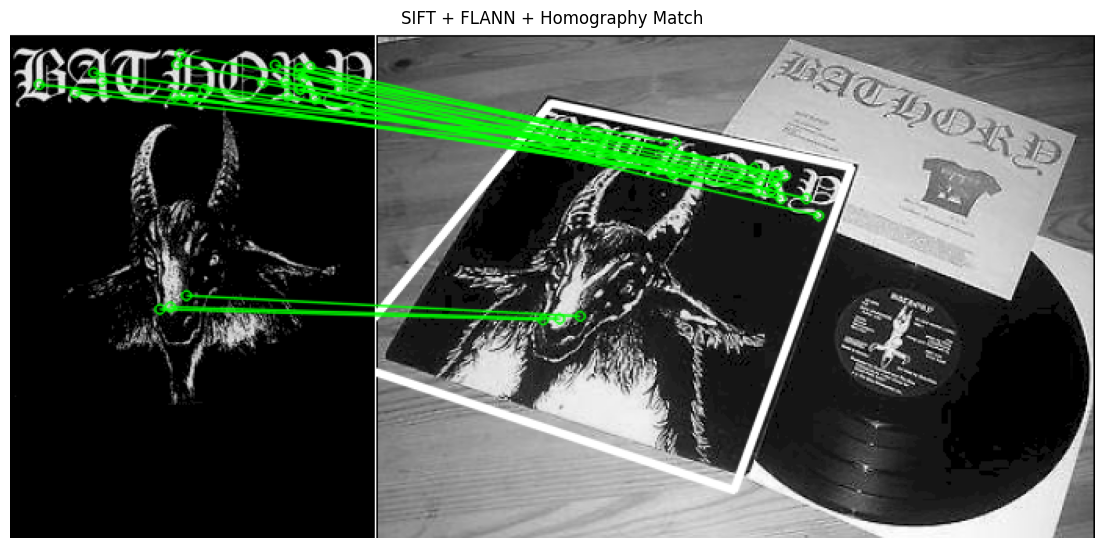

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab import files

# Upload 2 images
print("📁 Upload two images (query and target):")
uploaded = files.upload()
file_names = list(uploaded.keys())

if len(file_names) != 2:
    raise Exception("Please upload exactly two images.")

# Read images as grayscale
img1 = cv2.imread(file_names[0], 0)  # Query image
img2 = cv2.imread(file_names[1], 0)  # Scene image

# Create SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Define FLANN matcher
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Lowe's ratio test
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

# Minimum match count to proceed
MIN_MATCH_COUNT = 10

if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    # Find Homography using RANSAC
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    # Draw polygon on matched region
    h, w = img1.shape
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)
    img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

else:
    print("❗ Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
    matchesMask = None

# Draw matches
draw_params = dict(
    matchColor=(0, 255, 0),
    singlePointColor=None,
    matchesMask=matchesMask,
    flags=2
)

result_img = cv2.drawMatches(img1, kp1, img2, kp2, good, None, **draw_params)

# Display result
plt.figure(figsize=(14, 7))
plt.imshow(result_img, cmap='gray')
plt.axis("off")
plt.title("SIFT + FLANN + Homography Match")
plt.show()
